# Simple Shapes

## Setup

In [139]:
import os
import imageio
from collections import deque

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline  

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.1.0


In [4]:
device_name = tf.test.gpu_device_name()
print(device_name)

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4141126050660845294, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1906127953938200248
 physical_device_desc: "device: XLA_CPU device"]

## Load Data

In [268]:
NUMPIXELS = 64
INPUTSHAPE = (NUMPIXELS, NUMPIXELS, 1)
NUMCLASSES = 2
DATASIZE = 20000

In [199]:
data_path = os.path.join('/', 'home', 'jupyter', 'taureau', '_data')
shapes_path = os.path.join(data_path, 'simple_shapes', 'simple_shapes_'+str(NUMPIXELS))

In [269]:
def load_data(shapes_path):
    shape_info = pd.read_csv(os.path.join(shapes_path, 'data.csv'), header=None, names=["uid","shape","x0","y0","x1","y1"])
    shape_info = shape_info.sort_values('uid').reset_index(drop=True)
    shape_info.replace({'Ellipse':0, 'Rectangle':1}, inplace=True)
    shape_info = shape_info[shape_info.uid<=DATASIZE]
    img_data = deque()
    for uid in shape_info.uid.values:
        im = imageio.imread(os.path.join(shapes_path, 'images', 'img_'+str(uid)+'.png'))
        img_data.append(im)
    img_data = np.array(img_data)
    return (img_data, shape_info.values)

In [270]:
%%time

(x_data, y_data) = load_data(shapes_path)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
x_train = x_train.reshape(len(x_train), NUMPIXELS, NUMPIXELS, 1).astype('float32')/255
x_test = x_test.reshape(len(x_test), NUMPIXELS, NUMPIXELS, 1).astype('float32')/255

y_cls_train = tf.keras.utils.to_categorical(y_train[:,1])
y_cls_test = tf.keras.utils.to_categorical(y_test[:,1])

y_reg_train = y_train[:,2:6]
y_reg_test = y_test[:,2:6]

CPU times: user 10.5 s, sys: 1.7 s, total: 12.1 s
Wall time: 2min 2s


## Classification

In [202]:
inputs = tf.keras.Input(shape=INPUTSHAPE, name='img')
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(NUMCLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_cnn')

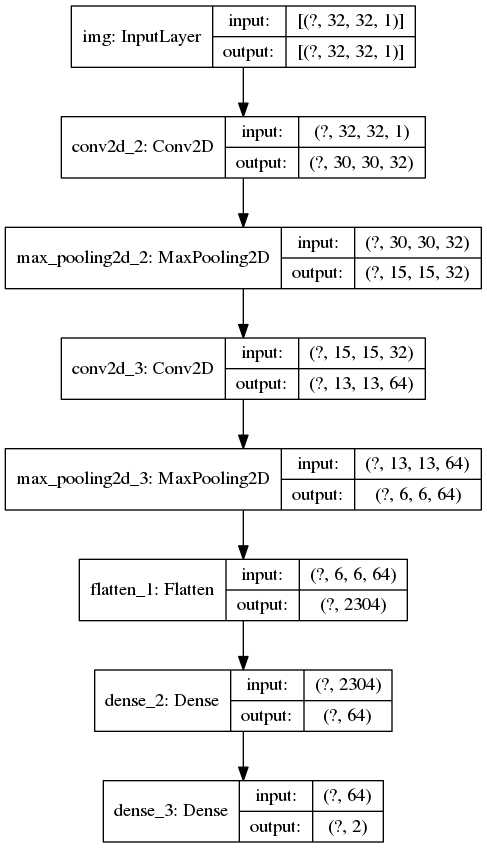

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [203]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [91]:
history = model.fit(x_train, y_cls_train,
                    batch_size=64,
                    epochs=5
                   )
#                     ,
#                     validation_split=0.2)

Train on 1600 samples
Epoch 1/5
1600/1600 [==============================] - 5s 3ms/sample - loss: 0.7164 - accuracy: 0.5806
Epoch 2/5
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.5571 - accuracy: 0.7525
Epoch 3/5
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.3472 - accuracy: 0.8850
Epoch 4/5
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.2634 - accuracy: 0.9100
Epoch 5/5
1600/1600 [==============================] - 4s 2ms/sample - loss: 0.1565 - accuracy: 0.9581


In [92]:
test_scores = model.evaluate(x_test, y_cls_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

400/400 - 1s - loss: 0.0961 - accuracy: 0.9950
Test loss: 0.09607559204101562
Test accuracy: 0.995


[[0.997 0.003]]


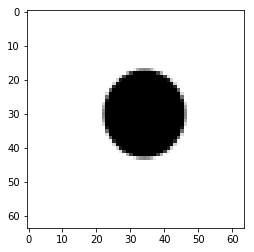

In [117]:
ind_r = np.random.randint(len(x_test))
# print(ind_r)

img_r = x_test[ind_r]
img_orig = img_r.reshape(NUMPIXELS, NUMPIXELS)
shape_pred = np.round(model.predict(np.array([img_r])), 3)
print(shape_pred)

fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(img_orig, cmap='gray')

plt.show()

## Regression

**NOTES**
Ideas for improvement:
- add one or more conv layers (see Chollet p141)
- add dropout layer after flatten 
- use custom loss that includes IOU term

In [271]:
inputs = tf.keras.Input(shape=INPUTSHAPE, name='img')
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(4)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_cnn')

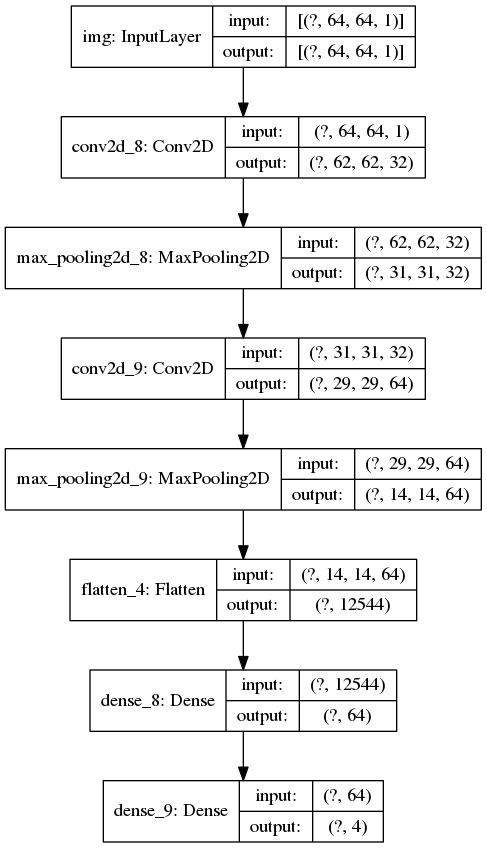

In [121]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [272]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['mse'])

In [273]:
history = model.fit(x_train, y_reg_train,
                    batch_size=64,
                    epochs=10
                   )
#                     ,
#                     validation_split=0.2)

Train on 16000 samples
Epoch 1/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 115.4610 - mse: 115.4611
Epoch 2/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 11.0522 - mse: 11.0522
Epoch 3/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 5.1231 - mse: 5.1231
Epoch 4/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 3.2871 - mse: 3.2871
Epoch 5/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 2.3336 - mse: 2.3336
Epoch 6/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 1.7326 - mse: 1.7326
Epoch 7/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 1.3979 - mse: 1.3979
Epoch 8/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 1.1845 - mse: 1.1845
Epoch 9/10
16000/16000 [==============================] - 34s 2ms/sample - loss: 1.0479 - mse: 1.0479
Epoch 10/10
16000/16000 [============================

In [274]:
test_scores = model.evaluate(x_test, y_reg_test, verbose=2)
print('Test loss:', test_scores[0])

4000/4000 - 3s - loss: 0.9836 - mse: 0.9836
Test loss: 0.9835799083709716


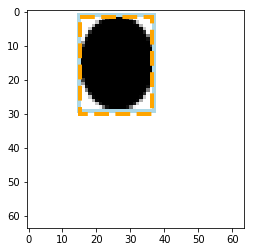

In [288]:
ind_r = np.random.randint(len(x_test))
# print(ind_r)

img_r = x_test[ind_r]
img_orig = img_r.reshape(NUMPIXELS, NUMPIXELS)
bbox_orig = y_reg_test[ind_r]
bbox_pred = model.predict(np.array([img_r]))[0]

fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(img_orig, cmap='gray')

rect = patches.Rectangle((bbox_orig[0]-1, (NUMPIXELS-bbox_orig[1])-(bbox_orig[3]-bbox_orig[1])),bbox_orig[2]-bbox_orig[0],bbox_orig[3]-bbox_orig[1], 
                         linewidth=4, edgecolor='lightblue', facecolor='none')
ax1.add_patch(rect)

rect2 = patches.Rectangle((bbox_pred[0]-1, (NUMPIXELS-bbox_pred[1])-(bbox_pred[3]-bbox_pred[1])),bbox_pred[2]-bbox_pred[0],bbox_pred[3]-bbox_pred[1], 
                         linewidth=4, edgecolor='orange', ls='--', facecolor='none')
ax1.add_patch(rect2)

plt.show()

## Regression + Classification

In [289]:
inputs = tf.keras.Input(shape=INPUTSHAPE, name='img')
x = layers.Conv2D(32, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Conv2D(64, 
                  kernel_size=(3, 3), 
                  strides=(1, 1), # default = (1,1)
                  activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2),
                        strides=(2, 2), # default = pool_size
                       )(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output_cls = layers.Dense(NUMCLASSES, activation='softmax')(x)
output_reg = layers.Dense(4)(x)
model = tf.keras.Model(inputs=inputs, outputs=[output_cls, output_reg], name='mnist_cnn')

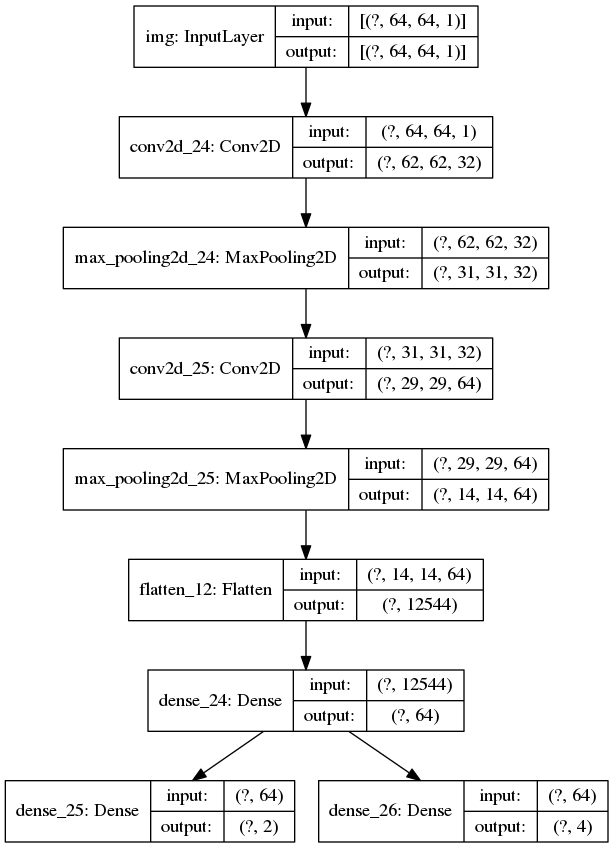

In [290]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [291]:
model.compile(loss=['categorical_crossentropy', 'mse'],
              optimizer=tf.keras.optimizers.Adam()
             )

In [293]:
history = model.fit(x_train, [y_cls_train, y_reg_train],
                    batch_size=64,
                    epochs=10
                   )
#                     ,
#                     validation_split=0.2)

Train on 16000 samples
Epoch 1/10
16000/16000 [==============================] - 37s 2ms/sample - loss: 101.7949 - dense_25_loss: 1.0211 - dense_26_loss: 100.7738
Epoch 2/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 15.3416 - dense_25_loss: 0.7915 - dense_26_loss: 14.5501
Epoch 3/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 5.9286 - dense_25_loss: 0.7099 - dense_26_loss: 5.2187
Epoch 4/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 3.6997 - dense_25_loss: 0.6141 - dense_26_loss: 3.0856
Epoch 5/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 2.8812 - dense_25_loss: 0.5400 - dense_26_loss: 2.3412
Epoch 6/10
16000/16000 [==============================] - 36s 2ms/sample - loss: 2.3443 - dense_25_loss: 0.4479 - dense_26_loss: 1.8964
Epoch 7/10
16000/16000 [==============================] - 35s 2ms/sample - loss: 1.6271 - dense_25_loss: 0.3335 - dense_26_loss: 1.2936
Epoch 8/10
16000/16

In [294]:
test_scores = model.evaluate(x_test, [y_cls_test, y_reg_test], verbose=2)
print('Test loss:', test_scores)

4000/4000 - 4s - loss: 1.2344 - dense_25_loss: 0.1660 - dense_26_loss: 1.0684
Test loss: [1.2344109292030334, 0.16596156, 1.0684495]


[0.926 0.074]


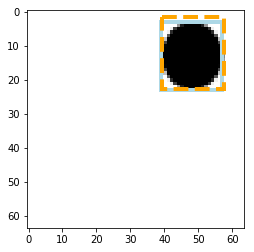

In [321]:
ind_r = np.random.randint(len(x_test))
# print(ind_r)

img_r = x_test[ind_r]
img_orig = img_r.reshape(NUMPIXELS, NUMPIXELS)
bbox_orig = y_reg_test[ind_r]
[shape_pred, bbox_pred] = model.predict(np.array([img_r]))
shape_pred = np.round(shape_pred[0], 3)
bbox_pred = bbox_pred[0]
print(shape_pred)

fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(img_orig, cmap='gray')

rect = patches.Rectangle((bbox_orig[0]-1, (NUMPIXELS-bbox_orig[1])-(bbox_orig[3]-bbox_orig[1])),bbox_orig[2]-bbox_orig[0],bbox_orig[3]-bbox_orig[1], 
                         linewidth=4, edgecolor='lightblue', facecolor='none')
ax1.add_patch(rect)

rect2 = patches.Rectangle((bbox_pred[0]-1, (NUMPIXELS-bbox_pred[1])-(bbox_pred[3]-bbox_pred[1])),bbox_pred[2]-bbox_pred[0],bbox_pred[3]-bbox_pred[1], 
                         linewidth=4, edgecolor='orange', ls='--', facecolor='none')
ax1.add_patch(rect2)

plt.show()